In [4]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import networkx as nx
import asyncio
import aiohttp
import matplotlib.pyplot as plt
import powerlaw

In [5]:
import os
import json

# Specify the path to the folder containing JSON files
data_folder_path = './data/'

# Create an empty dictionary to store data
all_data = {}

# Iterate over all files in the folder
for filename in os.listdir(data_folder_path):
    if filename.endswith(".json"):
        # Form the complete path to the JSON file
        json_file_path = os.path.join(data_folder_path, filename)
        
        # Read the JSON file and store its content in the dictionary
        with open(json_file_path, 'r') as file:
            # Use the filename (without extension) as the key in the dictionary
            all_data[os.path.splitext(filename)[0]] = json.load(file)

# Evolving graphs with nodes of characters and no edges

In [6]:
# # Initialize graph and graph dict to append the graphs
# season_data = all_data["episodes_seasons_characters"]["Naruto: Original"] # Getting the first seasons from the data file
# graph_dict = {}  # Initialize an empty dictionary to store graphs
# count = 1 # Initializing a count

# # Loop over every episode
# for i in range(len(season_data)):
#     G = nx.Graph()  # Create a new graph for each episode
#     characters = season_data[i]["Episode Characters"] # Characters from each episode as a list
    
#     # Add nodes from the previous graph (if it exists). Control statement for the first graph
#     if count > 1:
#         G.add_nodes_from(graph_dict[f'G{count-1}'].nodes) # Getting the nodes (characters) from the previous graph (episode)

#     # Add new characters as nodes
#     if characters is not None: # Control statement if the list of characters is empty/None type
#         G.add_nodes_from(characters) # Adding the characters

#     graph_dict[f'G{count}'] = G # Appending the evolving graph to the dictionary
#     count += 1 # Updating the count

# Evolving directed graph with nodes as characters and weighted edges

In [50]:
def create_character_interaction_graph(data, season=None):
    graph_dict = {}  # Initialize an empty dictionary to store graphs
    count = 1  # Initializing a count

    # Loop over every season
    if season is None:
        for season_name, episodes_data in data["episodes_seasons_characters"].items():
            for i in range(len(episodes_data)):
                G = nx.Graph()  # Create a new directed graph for each episode
                characters = episodes_data[i]["Episode Characters"]  # Characters from each episode as a list

                # Add nodes from the previous graph (if it exists). Control statement for the first graph
                if count > 1:
                    G.add_nodes_from(graph_dict[f'G{count-1}'].nodes)  # Getting the nodes (characters) from the previous graph (episode)

                    # Add edges and update weights from the previous graph
                    for edge in graph_dict[f'G{count-1}'].edges(data=True):
                        char1, char2, data = edge
                        weight = data.get('weight', 0)
                        G.add_edge(char1, char2, weight=weight)

                # Add new characters as nodes
                if characters is not None:  # Control statement if the list of characters is empty/None type
                    G.add_nodes_from(characters)  # Adding the characters

                    # Add weighted edges for characters appearing in the same episode
                    for char1 in characters:
                        for char2 in characters:
                            if char1 != char2:
                                if G.has_edge(char1, char2):
                                    G[char1][char2]['weight'] += 1
                                else:
                                    G.add_edge(char1, char2, weight=1)

                graph_dict[f'G{count}'] = G  # Appending the evolving graph to the dictionary
                count += 1  # Updating the count

    else:
        # Initialize graph and graph dict to append the graphs
        season_data = all_data["episodes_seasons_characters"][season]  
        graph_dict = {}  # Initialize an empty dictionary to store graphs
        count = 1  # Initializing a count

        # Loop over every episode
        for i in range(len(season_data)):
            G = nx.Graph()  # Create a new directed graph for each episode
            characters = season_data[i]["Episode Characters"]  # Characters from each episode as a list

            # Add nodes from the previous graph (if it exists). Control statement for the first graph
            if count > 1:
                G.add_nodes_from(graph_dict[f'G{count-1}'].nodes)  # Getting the nodes (characters) from the previous graph (episode)
                
                # Add edges and update weights from the previous graph
                for edge in graph_dict[f'G{count-1}'].edges(data=True):
                    char1, char2, data = edge
                    weight = data.get('weight', 0)
                    G.add_edge(char1, char2, weight=weight)

            # Add new characters as nodes
            if characters is not None:  # Control statement if the list of characters is empty/None type
                G.add_nodes_from(characters)  # Adding the characters

                # Add weighted edges for characters appearing in the same episode
                for char1 in characters:
                    for char2 in characters:
                        if char1 != char2:
                            if G.has_edge(char1, char2):
                                G[char1][char2]['weight'] += 1
                            else:
                                G.add_edge(char1, char2, weight=1)

            graph_dict[f'G{count}'] = G  # Appending the evolving graph to the dictionary
            count += 1  # Updating the count
    
    return graph_dict



In [53]:
graph_dict_first_season = create_character_interaction_graph(all_data, season='Naruto: Original')
graph_dict_all_seasons = create_character_interaction_graph(all_data)

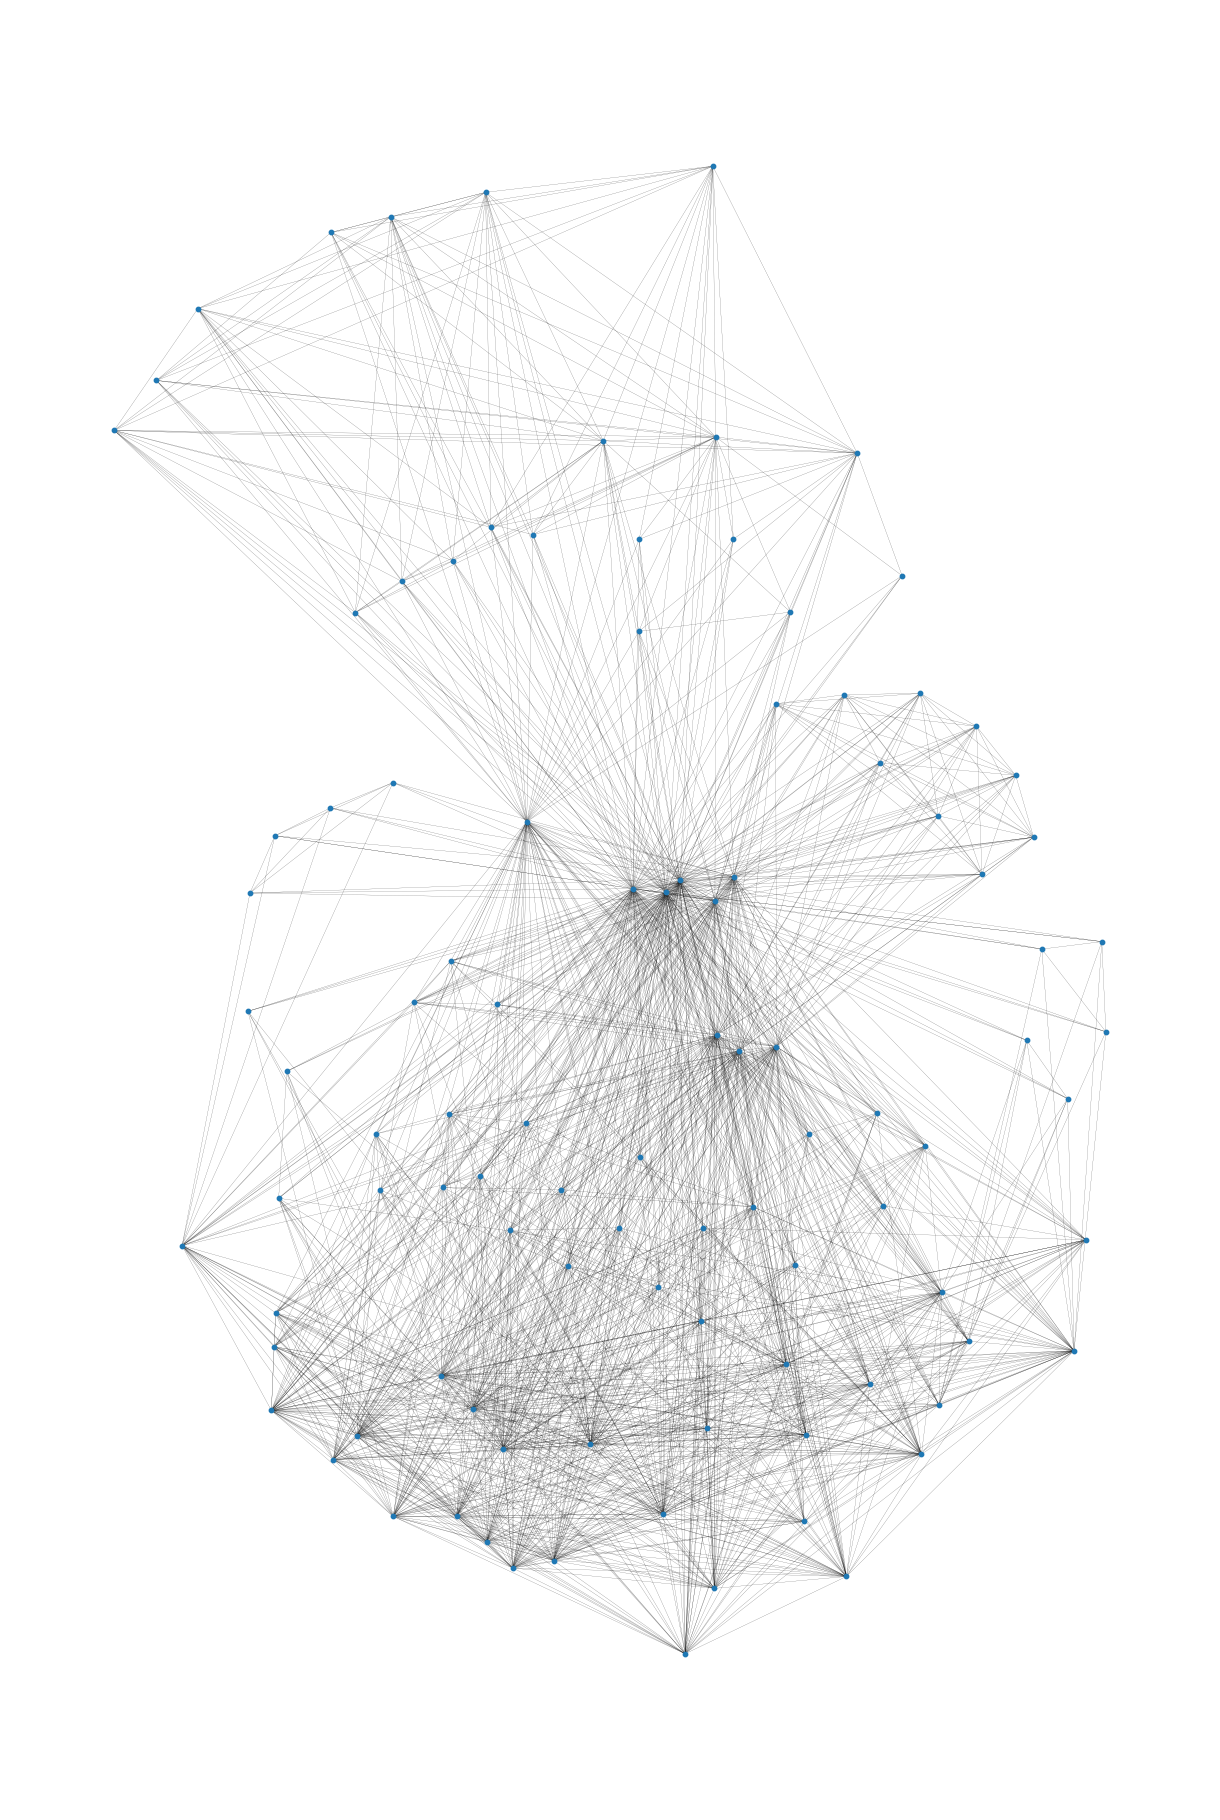

In [54]:
G50 = graph_dict_first_season["G50"]
# Draw the graph with smaller nodes
plt.figure(figsize=(12, 18))
pos = nx.kamada_kawai_layout(G50, scale=8.0)  # You can use different layout algorithms
nx.draw(G50, pos, node_size= 10, width=0.1)  # Adjust node_size as needed

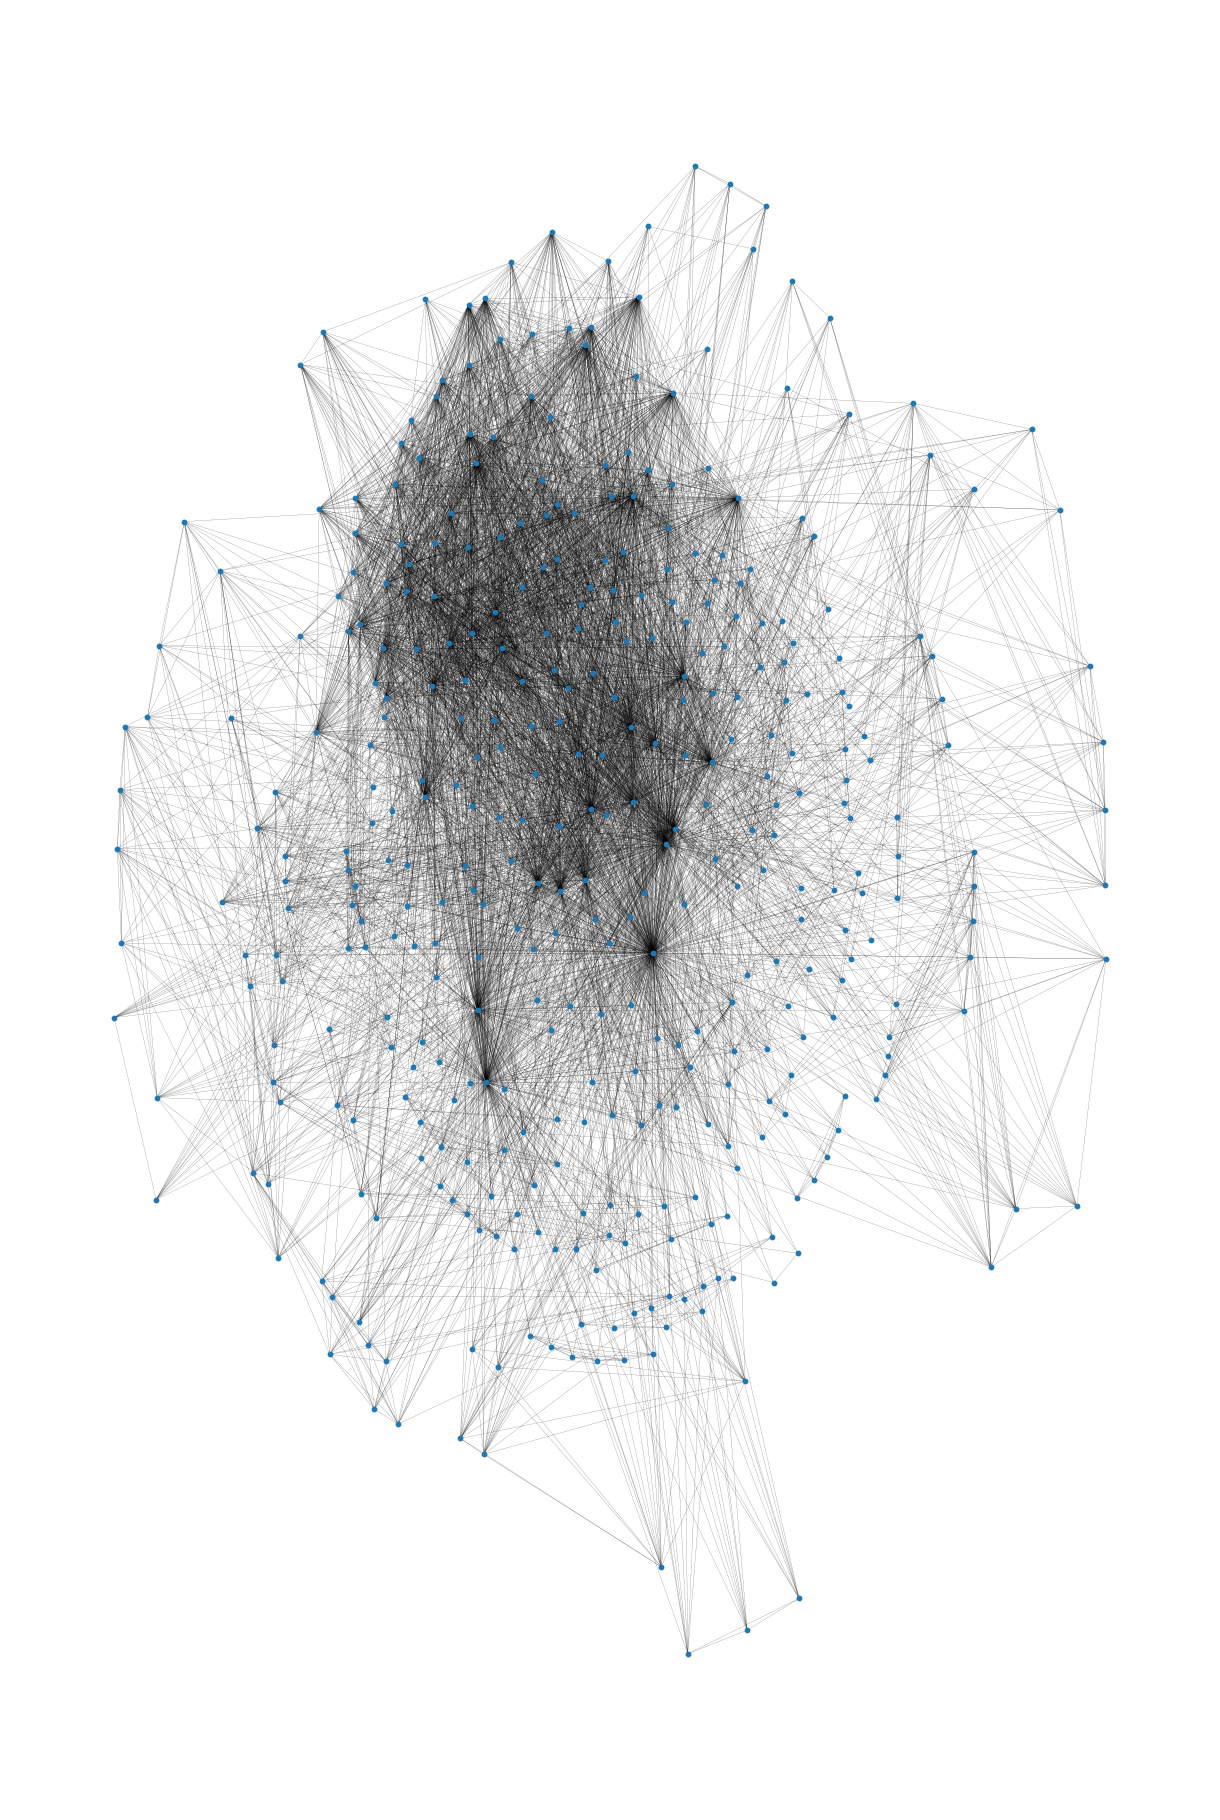

In [55]:
G220 = graph_dict_first_season["G220"]
degree_dict = degrees = dict(G220.degree())

# Draw the graph with smaller nodes
plt.figure(figsize=(12, 18))
pos = nx.kamada_kawai_layout(G220, scale=8.0)  # You can use different layout algorithms
node_size=[v * 3 for v in degree_dict.values()]
nx.draw(G220, pos, node_size= 10, width=0.1)  # Adjust node_size as needed

# Show the plot
plt.show()

In [56]:
def filter_edges_below_threshold(graph, threshold):
    # Create a copy of the graph to avoid modifying the original graph
    filtered_graph = graph.copy()

    # Iterate through edges and remove those below the threshold
    edges_to_remove = [(u, v) for u, v, w in graph.edges(data='weight') if w < threshold]
    filtered_graph.remove_edges_from(edges_to_remove)

    # Identify isolated nodes and remove them
    isolated_nodes = [node for node in filtered_graph.nodes() if filtered_graph.degree(node) == 0]
    filtered_graph.remove_nodes_from(isolated_nodes)

    return filtered_graph

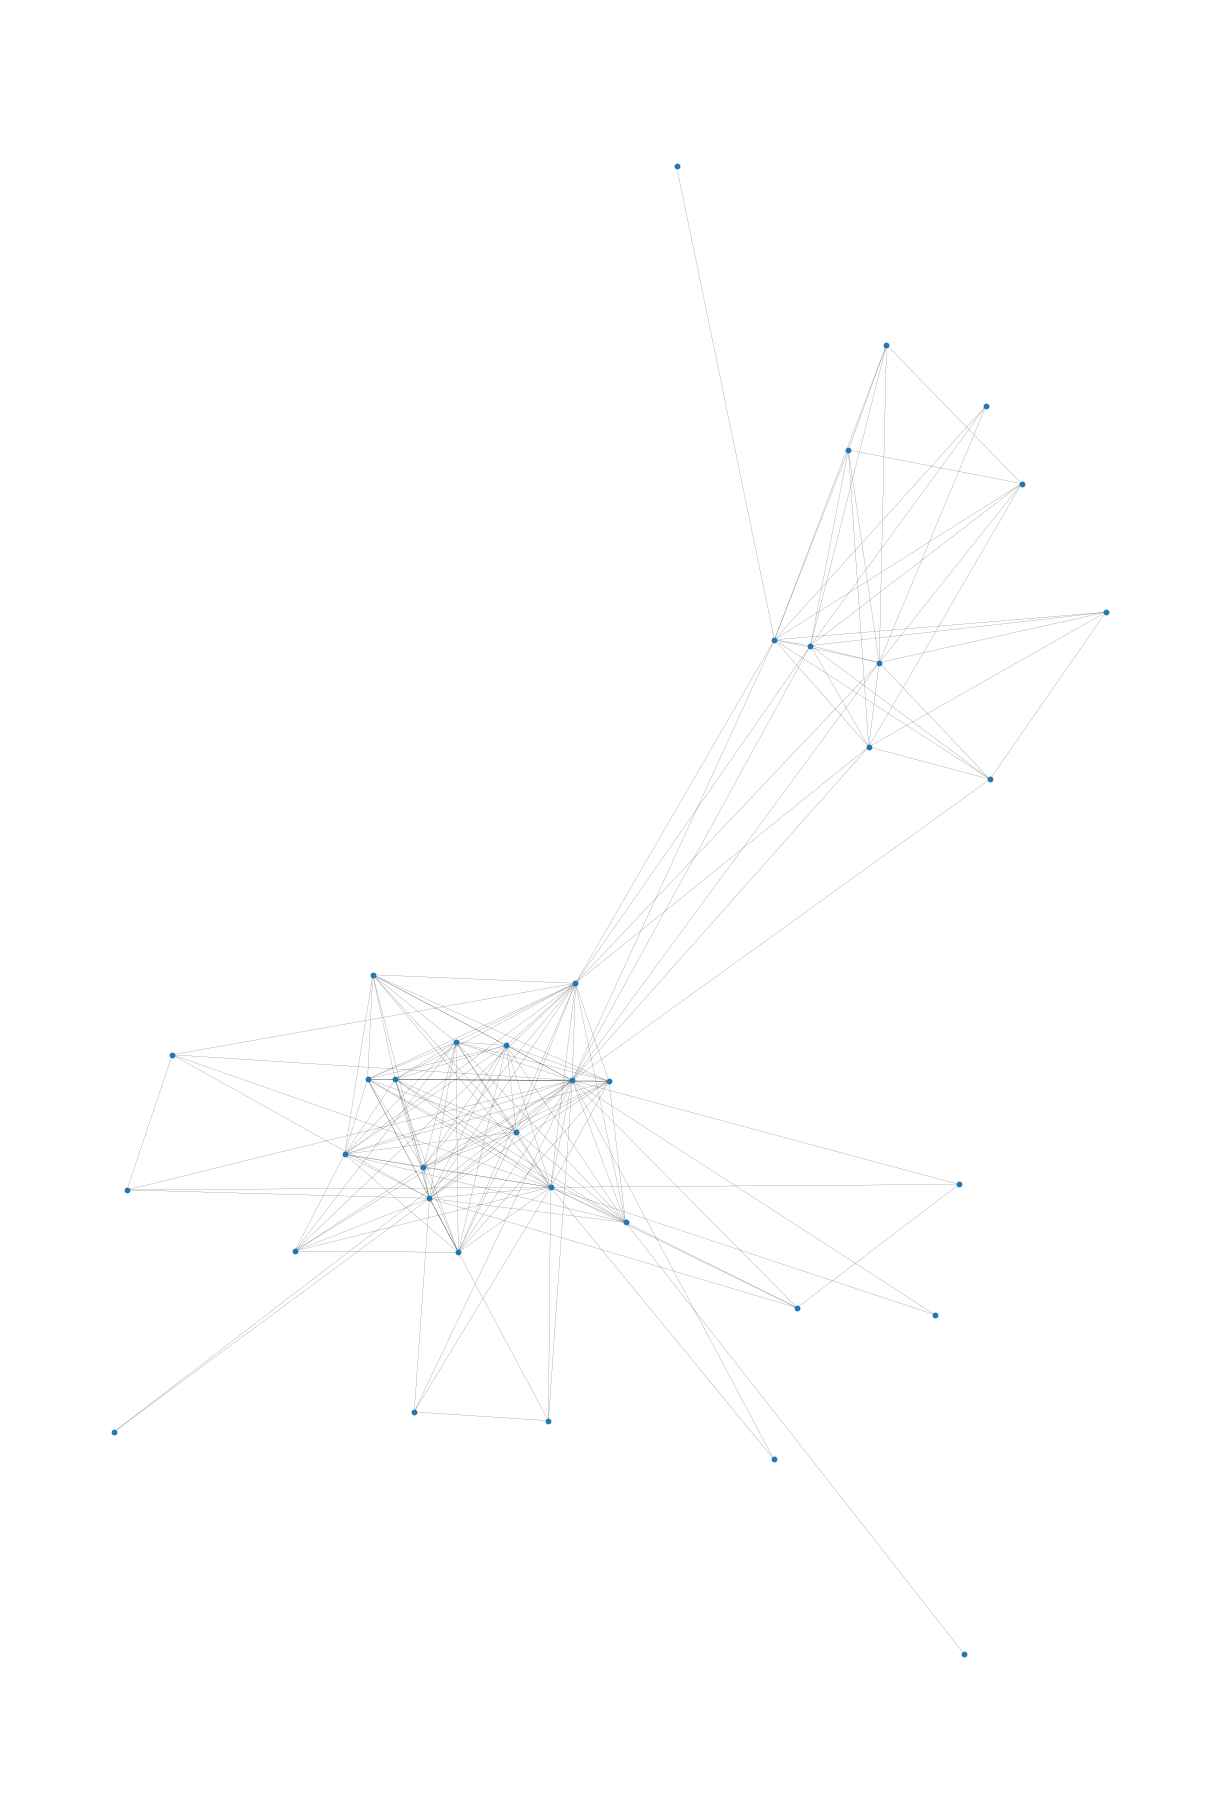

In [58]:
G1013_filtered = filter_edges_below_threshold(graph_dict_all_seasons['G1013'], 100)

plt.figure(figsize=(12, 18))
pos = nx.spring_layout(G1013_filtered, scale=8.0)  
nx.draw(G1013_filtered, pos, node_size= 10, width=0.1, with_labels=False)